# Interpolation matrix from uniform to chebyshev grid
Goal: figure out why the interpolation matrix blows up when going from the uniform to chebyshev grid.

In [1]:
import os
import jax
import jax.numpy as jnp
from scipy.io import savemat
import matplotlib.pyplot as plt

from timeit import default_timer
import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)

2025-06-26 14:40:48.679:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-26 14:40:48.679:jaxhps: DEBUG - Creating converter from 5 to 7
2025-06-26 14:40:48.680:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-26 14:40:48.680:jaxhps: DEBUG - Creating converter from 5 to 7


In [2]:
from jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from jaxhps.merge import merge_stage_uniform_2D_ItI
from jaxhps.down_pass import down_pass_uniform_2D_ItI
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)
from src.jaxhps import (
    Domain as MyDomain,
    DiscretizationNode2D as MyDiscretizationNode2D
)
from jaxhps._grid_creation_2D import (
    rearrange_indices_ext_int as rearrange_indices_ext_int_2D,
)
from jaxhps.quadrature import (
    barycentric_lagrange_interpolation_matrix_1D,
    barycentric_lagrange_interpolation_matrix_2D,
    chebyshev_points,
)
from jaxhps._interpolation_methods import interp_to_hps_2D
INTERP_BATCH_SIZE = 20

## Basic setup

In [3]:
q_fn_handle = lambda x: q_gaussian_bumps(0.75 * x)
domain_bounds = jnp.array([-1., 1., -1., 1.])

In [4]:
leaf_root = DiscretizationNode2D(-1., 1., -1., 1.)

n_per_leaf = 12
leaf_p = 16
leaf_domain = Domain(p=leaf_p, q=leaf_p-2, root=leaf_root, L=0)

In [5]:
# Interpolation setup
leaf_cheb_x = chebyshev_points(leaf_p)
leaf_cheb_y = chebyshev_points(leaf_p)[::-1]

cell_offset = 0 # errors are much here, but maybe this is coincidental
# cell_offset = 1/n_per_leaf # symmetric about zero, which seems appealing
leaf_unif_x = cell_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False)
leaf_unif_y = cell_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False) # [::-1]

product_grid = lambda xs, ys: jnp.array(jnp.meshgrid(xs, ys, indexing="ij")).transpose(1,2,0).reshape(-1,2)
leaf_cheb_xy = product_grid(leaf_cheb_x, leaf_cheb_y)
leaf_unif_xy = product_grid(leaf_unif_x, leaf_unif_y)
# leaf_cheb_xy = jnp.array(jnp.meshgrid(leaf_cheb_x, leaf_cheb_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
# leaf_unif_xy = jnp.array(jnp.meshgrid(leaf_unif_x, leaf_unif_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
q_leaf_unif = q_fn_handle(leaf_unif_xy)
q_leaf_cheb = q_fn_handle(leaf_cheb_xy)

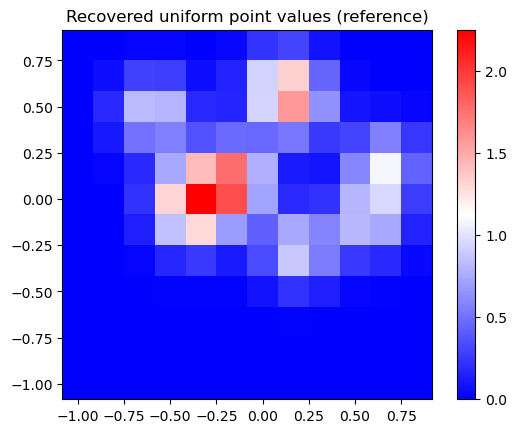

In [6]:
vis_slice = jnp.s_[:]
plt.title(f"Recovered uniform point values (reference)")
plt.pcolormesh(leaf_unif_x, leaf_unif_y, jnp.real(q_leaf_unif).reshape(n_per_leaf, n_per_leaf), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## Revisit 2D interpolation code

In [7]:
tmp_interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_x,
    from_pts_y=leaf_cheb_y,
    to_pts_x=leaf_unif_x,
    to_pts_y=leaf_unif_y,
)
rearrange_idcs = rearrange_indices_ext_int_2D(leaf_p)
interp_leaf_cheb_to_unif = tmp_interp_leaf_cheb_to_unif[:, rearrange_idcs]

In [8]:
tmp_interp_leaf_unif_to_cheb = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_unif_x,
    from_pts_y=leaf_unif_y,
    to_pts_x=leaf_cheb_x,
    to_pts_y=leaf_cheb_y,
)
# rearrange_idcs_2 = jnp.argsort(rearrange_indices_ext_int_2D(leaf_p))
rearrange_idcs_2 = rearrange_indices_ext_int_2D(leaf_p)
interp_leaf_unif_to_cheb = tmp_interp_leaf_unif_to_cheb[rearrange_idcs_2, :]

In [9]:
tmp_interp_leaf_unif_to_cheb.min(), tmp_interp_leaf_unif_to_cheb.max()

(Array(-731807.99999951, dtype=float64), Array(853775.99999942, dtype=float64))

## Sanity check: inspect the 1D interpolation case

In [10]:
(lambda x: (x.min(), x.max())) (barycentric_lagrange_interpolation_matrix_1D(
    from_pts=leaf_unif_x,
    to_pts=leaf_cheb_x,
))

(Array(-924., dtype=float64), Array(792., dtype=float64))

In [11]:
(lambda x: (x.min(), x.max())) (barycentric_lagrange_interpolation_matrix_1D(
    from_pts=leaf_cheb_x,
    to_pts=leaf_unif_x,
))

(Array(-0.21573787, dtype=float64), Array(1.00107302, dtype=float64))

In [12]:
jnp.abs(leaf_cheb_x[:, None] - leaf_unif_x[None, :]).min()

Array(0., dtype=float64)

It appears that the core issue is the Runge phenomenon, in which polynomial interpolation becomes very unstable near the boundaries of an interval if using equally spaced grid points.

## Bicubic interpolation for uniform to chebyshev?
Considerations:
Will this still be separable? Can I do it leaf-wise?

Well, actually I could use the existing interpolation code from the MFISNets repo

In [13]:
from rlc_repo_link.src.data.data_transformations import (
    prep_conv_interp_2d,
    apply_interp_2d,
    # Maybe I could leverage the separability to use the 1d operators?
    prep_conv_interp_1d,
    apply_interp_1d,
)

In [14]:
unif_to_cheb_x, unif_to_cheb_y = prep_conv_interp_2d(
    leaf_unif_x,
    leaf_unif_y,
    leaf_cheb_xy,
    # use a zero-valued boundary condition to mimic empty neighboring leaves
    bc_modes=("zero", "zero"),
)

In [15]:
q_leaf_cheb_from_unif = apply_interp_2d(
    unif_to_cheb_x,
    unif_to_cheb_y,
    q_leaf_unif.reshape(n_per_leaf, n_per_leaf),
).reshape(leaf_p, leaf_p)
# [rearrange_idcs_2].reshape(leaf_p, leaf_p)

In [16]:
q_leaf_cheb_err = (
    jnp.linalg.norm(q_leaf_cheb_from_unif - q_leaf_cheb.reshape(leaf_p, leaf_p))
    / jnp.linalg.norm(q_leaf_cheb)
)
print(f"Relative error on cheb grid: {q_leaf_cheb_err:.5e}")

Relative error on cheb grid: 1.51409e-01


In [17]:
# Error plummets if you cut out the three outermost layers
# So, the interpolation is quite good in the inside but bad on the outside.

hbw = 1 # hidden boundary width
inner_slice = jnp.s_[:,:] if hbw==0 else jnp.s_[hbw:-hbw, hbw:-hbw]
q_leaf_cheb_slice_err = (
    jnp.linalg.norm(
        q_leaf_cheb_from_unif[inner_slice]
        - q_leaf_cheb.reshape(leaf_p, leaf_p)[inner_slice])
    / jnp.linalg.norm(q_leaf_cheb.reshape(leaf_p, leaf_p)[inner_slice])
)
print(f"Relative error on cheb grid (slice): {q_leaf_cheb_slice_err:.5e}")

Relative error on cheb grid (slice): 1.46207e-01


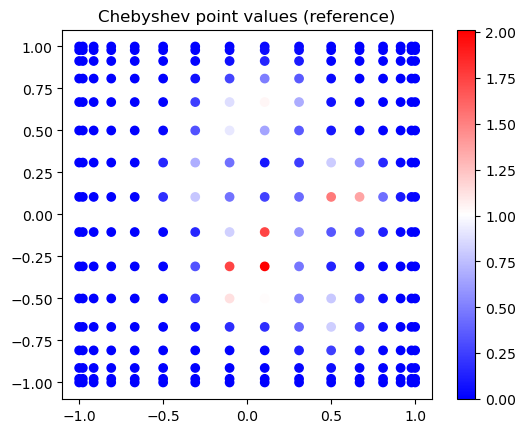

In [18]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev point values (reference)")
plt.scatter(*leaf_cheb_xy[vis_slice].T, c=jnp.real(q_leaf_cheb), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

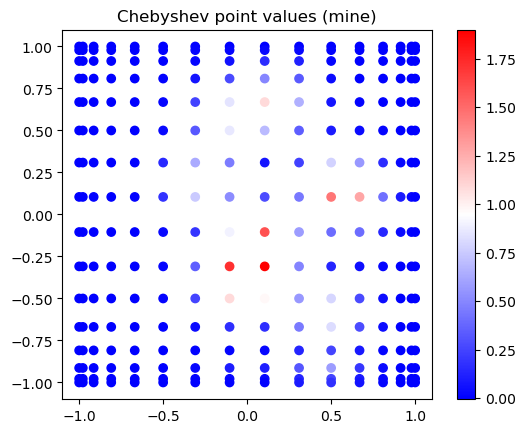

In [19]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev point values (mine)")
plt.scatter(*leaf_cheb_xy[vis_slice].T, c=jnp.real(q_leaf_cheb_from_unif), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

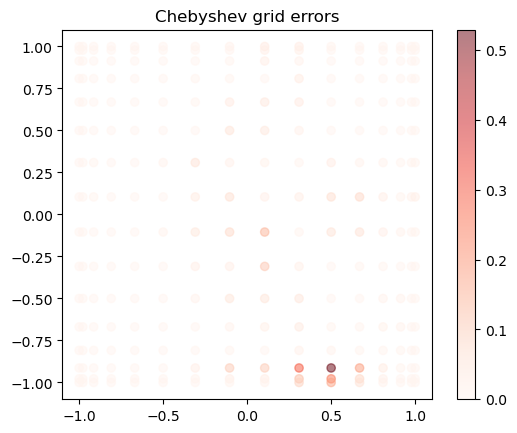

In [20]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev grid errors")
# plt.pcolormesh(
#     leaf_cheb_x,
#     leaf_cheb_y,
#     jnp.abs(
#         q_leaf_cheb_from_unif - q_leaf_cheb.reshape(leaf_p, leaf_p)
#     ),
#     cmap="hot"
# )
plt.scatter(
    *leaf_cheb_xy.T,
    c=jnp.abs(
        q_leaf_cheb_from_unif.flatten() - q_leaf_cheb
    ),
    alpha=0.5,
    cmap="Reds"
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

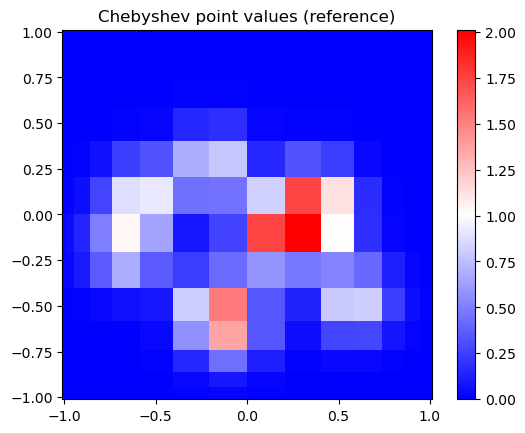

In [21]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev point values (reference)")
plt.pcolormesh(leaf_cheb_x, leaf_cheb_y, jnp.real(q_leaf_cheb).reshape(leaf_p, leaf_p), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

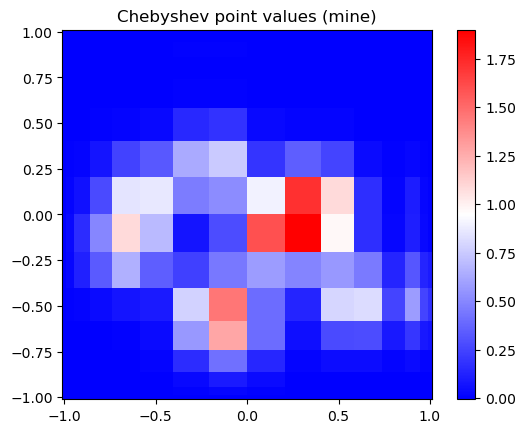

In [22]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev point values (mine)")
plt.pcolormesh(leaf_cheb_x, leaf_cheb_y, jnp.real(q_leaf_cheb_from_unif).reshape(leaf_p, leaf_p), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## Recovered uniform grid
Maybe the nodes look back in the chebyshev weighting, but maybe the mapping back onto the uniform grid is a bit better?

In [23]:
q_leaf_unif_recovered = (
    tmp_interp_leaf_cheb_to_unif @ q_leaf_cheb_from_unif.flatten()
).reshape(n_per_leaf, n_per_leaf)

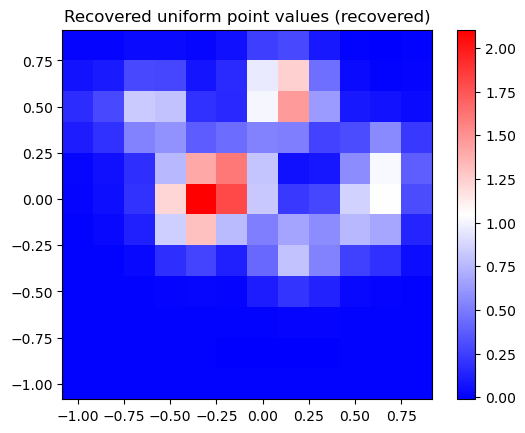

In [24]:
vis_slice = jnp.s_[:]
plt.title(f"Recovered uniform point values (recovered)")
plt.pcolormesh(leaf_unif_x, leaf_unif_y, jnp.real(q_leaf_unif_recovered).reshape(n_per_leaf, n_per_leaf), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

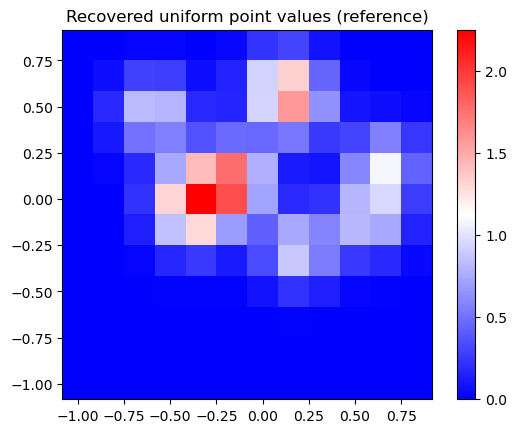

In [25]:
vis_slice = jnp.s_[:]
plt.title(f"Recovered uniform point values (reference)")
plt.pcolormesh(leaf_unif_x, leaf_unif_y, jnp.real(q_leaf_unif).reshape(n_per_leaf, n_per_leaf), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [26]:
hbw = 0 # hidden boundary width
inner_slice = jnp.s_[:,:] if hbw==0 else jnp.s_[hbw:-hbw, hbw:-hbw]
q_leaf_recovered_error = (
    jnp.linalg.norm((q_leaf_unif.reshape(n_per_leaf, n_per_leaf) - q_leaf_unif_recovered)[inner_slice])
) / jnp.linalg.norm(q_leaf_unif.reshape(n_per_leaf, n_per_leaf)[inner_slice])
print(f"Error of the recovered contents: {q_leaf_recovered_error:.5e}")

Error of the recovered contents: 8.33944e-02


In [27]:
hbw = 1 # hidden boundary width
inner_slice = jnp.s_[:,:] if hbw==0 else jnp.s_[hbw:-hbw, hbw:-hbw]
q_leaf_recovered_error = (
    jnp.linalg.norm((q_leaf_unif.reshape(n_per_leaf, n_per_leaf) - q_leaf_unif_recovered)[inner_slice])
) / jnp.linalg.norm(q_leaf_unif.reshape(n_per_leaf, n_per_leaf)[inner_slice])
print(f"Error of the recovered contents (slice): {q_leaf_recovered_error:.5e}")

Error of the recovered contents (slice): 7.54182e-02


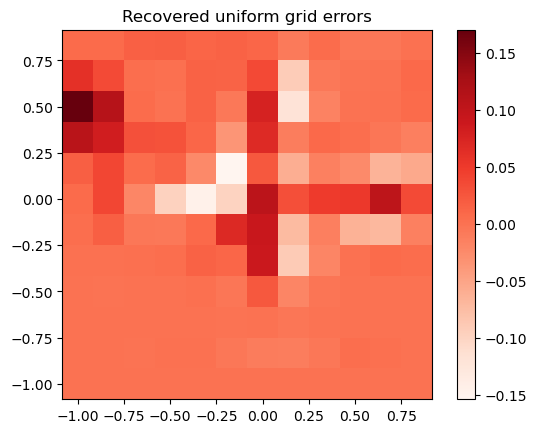

In [28]:
vis_slice = jnp.s_[:]
plt.title(f"Recovered uniform grid errors")
plt.pcolormesh(
    leaf_unif_x,
    leaf_unif_y,
    jnp.real(q_leaf_unif_recovered.flatten()-q_leaf_unif).reshape(n_per_leaf, n_per_leaf),
    cmap="Reds",
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## How about with a quadtree? are errors still high at the interface between leaf nodes?

In [29]:
def reorder_leaves_recursive_data(leaf_data: jax.Array, new_order: tuple=(3,2,0,1), L: int=None):
    """Recursively reorder the leaves in the requested order
    This function assumes that the provided data has the leaf index as the first axis.
    Suppose the inputs have children in labeled as [0,1,2,3]
        +-----+-----+-----+-----+
        |  0  |  1  |  2  |  3  |
        +-----+-----+-----+-----+
    This function will re-order the children within the flattened structure.
    For example, setting new_order=(3,2,0,1) would result in
        +-----+-----+-----+-----+
        |  3  |  2  |  0  |  1  |
        +-----+-----+-----+-----+
    which, in the quadtree, corresponds to an spatial organization of
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
    in terms of the input.
    Note: this function can be used to put the quadtree into Morton or Z order, but this
    is different from row-major order, as far as the blocks are concerned.

    Parameters:
        leaf_data (jax.Array): leaf data with shape (4**L, ...)
            the first axis indexes the different leaves, while successive axes are free
        L (int): number of levels in the quadtree
        new_order (tuple of ints): new relative ordering of the leaves
    Output:
        reordered_data (jax.array): re-ordered leaf data with shape (4**L, ...)
    """
    data_shape = leaf_data.shape
    extras_shape = data_shape[1:]
    L = L if L is not None else int(jnp.round(jnp.log2(data_shape[0])/2))
    new_order_array = jnp.array(new_order)
    tmp_data = jnp.copy(leaf_data)
    idcs = jnp.arange(data_shape[0])
    for l in range(0, L):
        idcs = idcs.reshape(4**l, 4, 4**(L-l-1))
        idcs = jnp.take(idcs, new_order_array, axis=1)
    reordered_data = jnp.take(leaf_data, idcs.flatten(), axis=0)
    return reordered_data

def reorder_leaves_indices(L: int, s: int = 1, new_order: tuple=(3,2,0,1)):
    """This function prepares the indices needed to recursively perform the 
    reordering operation as described below:

    Suppose the inputs have children in labeled as [0,1,2,3]
        +-----+-----+-----+-----+
        |  0  |  1  |  2  |  3  |
        +-----+-----+-----+-----+
    This function will re-order the children within the flattened structure.
    For example, setting new_order=(3,2,0,1) would result in
        +-----+-----+-----+-----+
        |  3  |  2  |  0  |  1  |
        +-----+-----+-----+-----+
    which, in the quadtree, corresponds to an spatial organization of
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
    in terms of the input.
    Note: this function can be used to put the quadtree into Morton or Z order, but this
    is different from row-major order, as far as the blocks are concerned.

    Parameters:
        L (int): number of levels in the quadtree
        s (int): number of entries per leaf in the quadtree
        new_order (tuple of ints): new relative ordering of the leaves
    Output:
        idcs (jax.array): re-ordered leaf index map with shape (4**L * s**2,)
            Can be used as jax.take(leaf_data, idcs, axis=<relevant axis>)
    """
    idcs = jnp.arange(4**L * s)
    new_order_array = jnp.array(new_order)
    for l in range(0, L):
        idcs = idcs.reshape(4**l, 4, 4**(L-l-1))
        idcs = jnp.take(idcs, new_order_array, axis=1)
    return idcs

def morton_to_flatten_indices(L: int, s: int, return_flat=True):
    """Converts the indices for morton ordering into a flattened structure
    Largely lifted from Matt Li's code; for my purposes s=1 seems sufficient
    """
    if L==0:
        res = jnp.arange(s**2).reshape(s,s) # no re-ordering necessary
    else:
        bsize = 4**(L-1) * s**2 # block size
        tmp = morton_to_flatten_indices(L-1, s, return_flat=False) # recurrence
        res = jnp.block([[tmp, tmp+bsize], [tmp+2*bsize, tmp+3*bsize]])
    return res.flatten() if return_flat else res

def prep_quadtree_to_unrolled_indices(L: int, s=1, new_order=(0,1,3,2)):
    """Prepares the indices needed to go from the quadtree ordering of
        +-----+-----+
        |  0  |  1  |
        +-----+-----+
        |  3  |  2  |
        +-----+-----+
    to an unrolled ordering based on the spatial layout:
        [[0 1 2   ... 2^L-1]
         [1+2^L   ...      ]
         [        ...      ]
         [4^L-2^L ... 4^L-1]
    Parameters:
        L (int): number of levels in the quadtree
        s (int): number of elements per level in the quadtree
        new_order (tuple): the new ordering of the blocks
            default:   (0,1,3,2)
            alternate: (3,2,0,1) (depends on the desired first-axis ordering)
    """
    quadtree_to_morton   = reorder_leaves_indices(L, s, new_order=new_order)
    morton_to_unrolled   = morton_to_flatten_indices(L, s)
    quadtree_to_unrolled = jnp.take(quadtree_to_morton, morton_to_unrolled)
    return quadtree_to_unrolled

def apply_quadtree_to_unrolled_indices(data: jax.Array, quadtree_to_unrolled: jax.Array, axis=0):
    """Super basic function to apply the indices, mostly for a reminder of the usage"""
    return jnp.take(data, quadtree_to_unrolled, axis=axis)

In [30]:
tree_root = DiscretizationNode2D(-1., 1., -1., 1.)
tree_L = 1
tree_n_per_leaf = 12
tree_n = 2**tree_L * tree_n_per_leaf
tree_p = 16
tree_domain = Domain(p=tree_p, q=tree_p-2, root=leaf_root, L=tree_L)

In [31]:
%time
# Setup work
# First, leaf re-ordering
quadtree_to_unrolled_idcs = prep_quadtree_to_unrolled_indices(tree_L)

# Next, leaf-level interpolation operation
tree_leaf_cheb_x = chebyshev_points(tree_p)
tree_leaf_cheb_y = chebyshev_points(tree_p)[::-1]
tree_cheb_x = jnp.concatenate(
    [
        (tree_leaf_cheb_x+1) * (1/2**tree_L) - 1 + (2*i/2**tree_L)
        for i in range(2**tree_L)
    ],
    axis=0
)
tree_cheb_y = jnp.concatenate(
    [
        (tree_leaf_cheb_y+1) * (1/2**tree_L) - 1 + (2*i/2**tree_L)
        for i in range(2**tree_L)
    ],
    axis=0
)

# cell_offset = 0
use_endpoint = False
cell_offset = 0 # 0.5 for centered
tree_leaf_unif_x = (cell_offset/tree_n_per_leaf)+jnp.linspace(-1, 1, tree_n_per_leaf, endpoint=use_endpoint)
tree_leaf_unif_y = (cell_offset/tree_n_per_leaf)+jnp.linspace(-1, 1, tree_n_per_leaf, endpoint=use_endpoint) # [::-1]
tree_unif_x = (cell_offset/tree_n)+jnp.linspace(-1, 1, tree_n, endpoint=use_endpoint)
tree_unif_y = (cell_offset/tree_n)+jnp.linspace(-1, 1, tree_n, endpoint=use_endpoint)

product_grid = lambda xs, ys: jnp.array(jnp.meshgrid(xs, ys, indexing="ij")).transpose(1,2,0).reshape(-1,2)
tree_leaf_cheb_xy = product_grid(tree_leaf_cheb_x, tree_leaf_cheb_y)
tree_leaf_unif_xy = product_grid(tree_leaf_unif_x, tree_leaf_unif_y)
tree_unif_xy = product_grid(tree_unif_x, tree_unif_y)
tree_cheb_xy = product_grid(tree_cheb_x, tree_cheb_y)
# tree_leaf_cheb_xy = jnp.array(jnp.meshgrid(tree_leaf_cheb_x, tree_leaf_cheb_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
# tree_leaf_unif_xy = jnp.array(jnp.meshgrid(tree_leaf_unif_x, tree_leaf_unif_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
# tree_unif_xy = jnp.array(jnp.meshgrid(tree_unif_x, tree_unif_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)
# tree_cheb_xy = jnp.array(jnp.meshgrid(tree_cheb_x, tree_cheb_y, indexing="ij")).transpose(1,2,0).reshape(-1,2)

tmp_interp_tree_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_x,
    from_pts_y=leaf_cheb_y,
    to_pts_x=leaf_unif_x,
    to_pts_y=leaf_unif_y,
)
tree_leaf_rearrange_idcs = rearrange_indices_ext_int_2D(tree_p)
inv_tree_leaf_rearrange_idcs = jnp.argsort(tree_leaf_rearrange_idcs)
interp_tree_leaf_cheb_to_unif = tmp_interp_tree_leaf_cheb_to_unif[:, tree_leaf_rearrange_idcs]

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.29 μs


In [32]:
ref_q_tree_unif = q_fn_handle(tree_unif_xy)
ref_q_tree_cheb = q_fn_handle(tree_domain.interior_points)

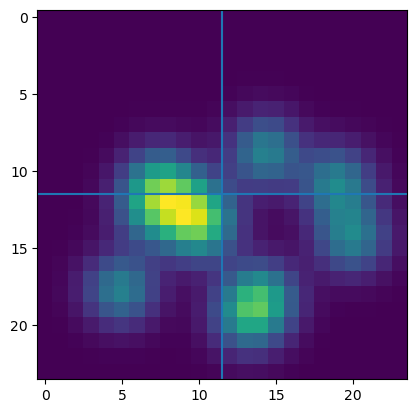

In [33]:
plt.imshow(
    ref_q_tree_unif.reshape(tree_n, tree_n)
)
plt.axvline(n_per_leaf-0.5)
plt.axhline(n_per_leaf-0.5)

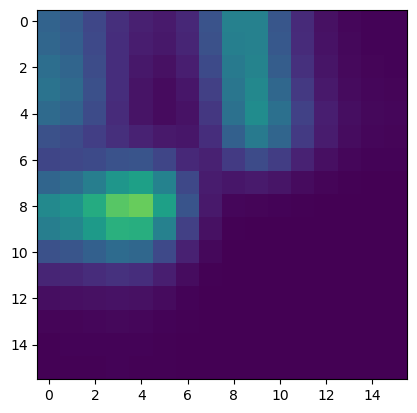

In [34]:
# I confused myself about the layout...
plt.imshow(
    ref_q_tree_cheb[quadtree_to_unrolled_idcs][3]
    [inv_tree_leaf_rearrange_idcs]
    .reshape(tree_p, tree_p)
    [:, ::-1]
    ,
    vmin=ref_q_tree_unif.min(),
    vmax=ref_q_tree_unif.max(),
    
)

In [35]:
ref_q_tree_cheb_2d = (
    ref_q_tree_cheb
    # [jnp.argsort(quadtree_to_unrolled_idcs), :] # not sure why this isn't working
    [jnp.array([0,3,1,2]), :]
    [:, inv_tree_leaf_rearrange_idcs]
    .reshape(2**tree_L, 2**tree_L, tree_p, tree_p)
    # .transpose(0,3,1,2)
    .transpose(0,2,1,3)
    # [:, :, :, ::-1]
    .reshape(2**tree_L*tree_p, 2**tree_L*tree_p)
)

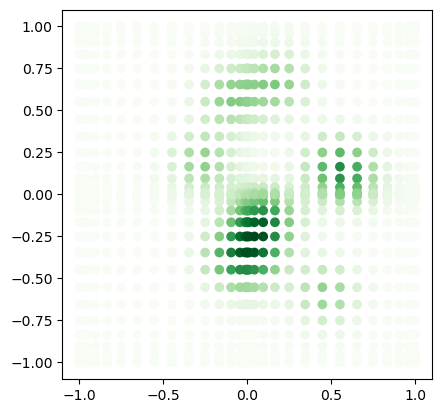

In [36]:
plt.scatter(
    *tree_cheb_xy.T,
    c=jnp.real(ref_q_tree_cheb_2d),
    cmap="Greens"
)
plt.gca().set_aspect(1)

In [37]:
# default chebyshev -> uniform
%time
# 1. Reorder the leaf nodes
reordered_leaves_q_tree_cheb = jnp.take(ref_q_tree_cheb, quadtree_to_unrolled_idcs, axis=0)
# 2. Perform the leaf-level operations
reordered_leaves_q_tree_unif = jnp.einsum(
    "jl,il...->ij...",
    interp_leaf_cheb_to_unif,
    reordered_leaves_q_tree_cheb
)
# 3. Reshape the leaf-level data into square matrices
# Why did I have to flip the two leaf dimensions???
my_q_tree_unif = (
    reordered_leaves_q_tree_unif
    .reshape(2**tree_L, 2**tree_L, tree_n_per_leaf, tree_n_per_leaf, *reordered_leaves_q_tree_unif.shape[2:])
    .transpose(0,3,1,2, *(jnp.arange(4,2+reordered_leaves_q_tree_unif.ndim)))
    # [::-1, ::-1, :, :, ...]
    .reshape(tree_n, tree_n, *reordered_leaves_q_tree_unif.shape[2:])
)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.53 μs


In [38]:
# Tree version of uniform -> chebyshev
# Setup
%time
tree_unif_to_cheb_x, tree_unif_to_cheb_y = prep_conv_interp_2d(
    tree_unif_x,
    tree_unif_y,
    tree_domain.interior_points.reshape(-1,2),
    # tree_cheb_xy,
    # use a zero-valued boundary condition to mimic empty neighboring leaves
    bc_modes=("zero", "zero"),
)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.77 μs


In [39]:
# Why don't I have to account for the leaf ordering or anything??
# big confusion

%time
q_tree_cheb_from_unif = (
    apply_interp_2d(
        tree_unif_to_cheb_x,
        tree_unif_to_cheb_y,
        ref_q_tree_unif.reshape(tree_n, tree_n),
    )
    # .reshape(2**tree_L * tree_p, 2**tree_L * tree_p)
    .reshape(4**tree_L, tree_p**2)
    # [jnp.argsort(quadtree_to_unrolled_idcs), :]
    [jnp.array([0,3,1,2]),:]
    [:, inv_tree_leaf_rearrange_idcs]
    .reshape(2**tree_L, 2**tree_L, tree_p, tree_p)
    .transpose(0,2,1,3)
    .reshape(2**tree_L * tree_p, 2**tree_L * tree_p)
)

# [rearrange_idcs_2].reshape(leaf_p, leaf_p)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.01 μs


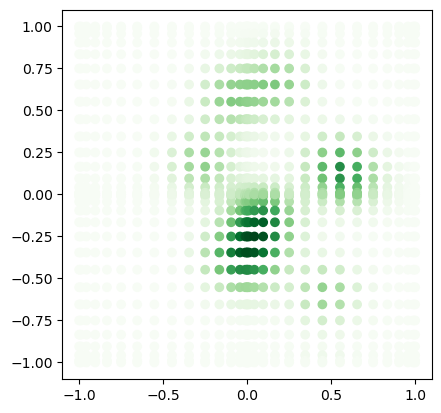

In [40]:
plt.scatter(
    *tree_cheb_xy.T,
    c=jnp.real(q_tree_cheb_from_unif),
    cmap="Greens"
)
plt.gca().set_aspect(1)

In [41]:
q_tree_cheb_err = (
    jnp.linalg.norm(q_tree_cheb_from_unif - ref_q_tree_cheb_2d)
    / jnp.linalg.norm(ref_q_tree_cheb_2d)
)
print(f"Error in chebyshev node values: {q_tree_cheb_err:.5e}")

Error in chebyshev node values: 1.46864e-02


## Wrap in functions/methods (tree level)
### First, do chebyshev->uniform

In [42]:
# Object version
class QuadtreeChebToUnif:
    """Class to interpolate data from quadtree form with chebyshev-grid leaves
    to a contiguous form on a uniform grid.
    Simplifying assumptions:
    1. Assume each leaf contains an integer number of points from the uniform grid,
    and that these points are always in the same positions relative to the leaf boxes
    2. Assume that the domain size does not change
    """
    def __init__(self, L: int, p: int, n_per_leaf: int, cell_offset: float = 0):
        """Set up the reusable objects
        Parameters:
            L (int): number of levels in the tree
            p (int): polynomial order of the leaf-level chebyshev grids 
            n_per_leaf (int): number of points in the uniform grid per leaf
            cell_offset (float): relative offset of where to sample the uniform grid
                If a leaf's chebyshev grid is sampled on the interval [-1, 1],
                the cell_offset values correspond to the following behavior:
                0:   default behavior, sample at    [0, 1, 2, ..., n_per_leaf-1]*2/n_per_leaf-1
                0.5: cell-centered, sample at       [0.5, 1.5, 2.5, ..., n_per_leaf-0.5]*2/n_per_leaf-1
                1:   sample on the opposite end, at [1, 2, ..., n_per_leaf]*2/n_per_leaf-1
        """
        self.L = L
        self.p = p
        self.n_per_leaf = n_per_leaf

        self.quadtree_to_unrolled_idcs = prep_quadtree_to_unrolled_indices(L)
        self.leaf_cheb_x = chebyshev_points(p)
        self.leaf_cheb_y = chebyshev_points(p)[::-1]

        self.cell_offset = cell_offset
        leaf_offset = cell_offset * 0.5/n_per_leaf
        self.leaf_unif_x = leaf_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False)
        self.leaf_unif_y = leaf_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False) # [::-1]

        tmp_interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
            from_pts_x=self.leaf_cheb_x,
            from_pts_y=self.leaf_cheb_y,
            to_pts_x=self.leaf_unif_x,
            to_pts_y=self.leaf_unif_y,
        )
        self.rearrange_leaf_idcs = rearrange_indices_ext_int_2D(p)
        self.interp_leaf_cheb_to_unif = tmp_interp_leaf_cheb_to_unif[:, self.rearrange_leaf_idcs]

    def apply(self, data_quadtree_cheb: jax.Array) -> jax.Array:
        """Applies the quadtree chebyshev-to-uniform operation
        Parameters:
            data_quadtree_cheb (jax.Array, shape: (4**L, p**2, ...)):
                Data from the HPS quadtree, sampled on Chebyshev grids at the leaf level
        Output:
            data_unif (jax.Array, shape (2**L * n_per_leaf, 2**L * n_per_leaf), ...):
                Data on the uniform grid without the quadtree structure
        """
        L = self.L
        p = self.p
        n_per_leaf = self.n_per_leaf
        leftover_shape = data_quadtree_cheb.shape[2:]
        leftover_idcs = 4 + jnp.arange(0, data_quadtree_cheb.ndim-2)

        # 1. Reorder the leaf nodes to a more standard ordering (~block-wise row-major-order)
        data_leaves_cheb = jnp.take(
            data_quadtree_cheb,
            self.quadtree_to_unrolled_idcs,
            axis = 0,
        )

        # 2. Map values from Chebyshev to Uniform grids on the leaf-level
        data_leaves_unif = jnp.einsum(
            "jl,il...->ij...",
            self.interp_leaf_cheb_to_unif,
            data_leaves_cheb
        )

        # 3. Reshape leaf-level data into square matrices, then rearrange
        data_unif = (
            data_leaves_unif
            .reshape(2**L, 2**L, n_per_leaf, n_per_leaf, *leftover_shape)
            .transpose(0,3,1,2, *leftover_idcs)
            .reshape(2**L * n_per_leaf, 2**L * n_per_leaf, *leftover_shape)

            # I don't know why the outputs need to be transposed here...
            .transpose(1,0, *(leftover_idcs-2))
        )
        return data_unif

In [43]:
quadtree_cheb_to_unif = QuadtreeChebToUnif(tree_L, tree_p, tree_n_per_leaf)

In [44]:
my_q_tree_cheb_fnver = quadtree_cheb_to_unif.apply(ref_q_tree_cheb)

In [45]:
orig_unif_interp_err = (
    jnp.linalg.norm(my_q_tree_cheb_fnver.flatten() - ref_q_tree_unif)
    / jnp.linalg.norm(ref_q_tree_unif)
)
flipped_unif_interp_err = (
    jnp.linalg.norm(my_q_tree_cheb_fnver.T.flatten() - ref_q_tree_unif) 
    / jnp.linalg.norm(ref_q_tree_unif)
)
print(f"Relative error vs q (original):   {orig_unif_interp_err:.5e}")
print(f"Relative error vs q (transposed): {flipped_unif_interp_err:.5e}")

Relative error vs q (original):   2.13142e-04
Relative error vs q (transposed): 9.14284e-01


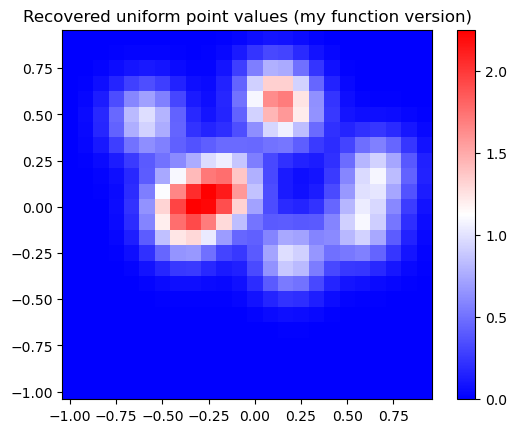

In [46]:
vis_slice = jnp.s_[:]
plt.title(f"Recovered uniform point values (my function version)")
plt.pcolormesh(
    tree_unif_x,
    tree_unif_y,
    jnp.real(my_q_tree_cheb_fnver),
    cmap="bwr"
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

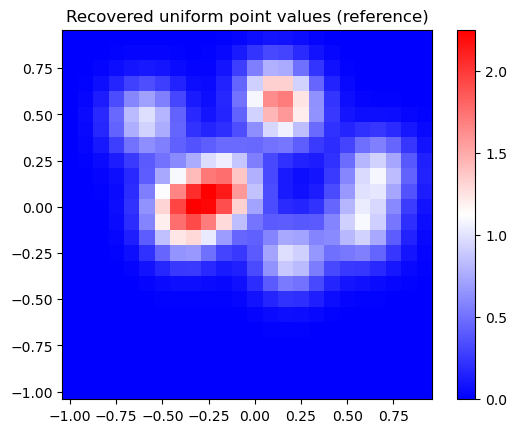

In [47]:
vis_slice = jnp.s_[:]
plt.title(f"Recovered uniform point values (reference)")
plt.pcolormesh(
    tree_unif_x,
    tree_unif_y,
    jnp.real(ref_q_tree_unif).reshape(tree_n, tree_n),
    cmap="bwr"
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

### Next, uniform -> chebyshev

In [48]:
class UnifToQuadtreeCheb:
    """Class to interpolate data from a contiguous uniform grid to
    a quadtree form with chebyshev-grid leaves. Uses bicubic interpolation.
    Simplifying assumptions:
    1. Assume each leaf contains an integer number of points from the uniform grid,
    and that these points are always in the same positions relative to the leaf boxes
    2. Assume that the domain size does not change
    For now, fix it at [-1, 1, -1, 1] for both input/output since the true scaling does
    not really matter, other than if the domain were non-square.
    """
    def __init__(self, L: int, p: int, n_per_leaf: int, cell_offset: float = 0):
        """Set up the reusable objects
        Parameters:
            L (int): number of levels in the tree
            p (int): polynomial order of the leaf-level chebyshev grids 
            n_per_leaf (int): number of points in the uniform grid per leaf
            cell_offset (float): relative offset of where to sample the uniform grid
                If a leaf's chebyshev grid is sampled on the interval [-1, 1],
                the cell_offset values correspond to the following behavior:
                0:   default behavior, sample at    [0, 1, 2, ..., n_per_leaf-1]*2/n_per_leaf-1
                0.5: cell-centered, sample at       [0.5, 1.5, 2.5, ..., n_per_leaf-0.5]*2/n_per_leaf-1
                1:   sample on the opposite end, at [1, 2, ..., n_per_leaf]*2/n_per_leaf-1
        """
        self.L = L
        self.p = p
        self.n_per_leaf = n_per_leaf
        n = 2**L * n_per_leaf
        self.n = n

        # permutation maps for ordering leaves and chebyshev points within the leaves
        self.quadtree_to_unrolled_idcs = prep_quadtree_to_unrolled_indices(L, new_order=(0,1,3,2))
        self.unrolled_to_quadtree_idcs = jnp.argsort(self.quadtree_to_unrolled_idcs) # invert
        self.rearrange_leaf_idcs       = rearrange_indices_ext_int_2D(p)
        self.inv_rearrange_leaf_idcs   = jnp.argsort(self.rearrange_leaf_idcs) # invert

        # leaf-level grids, for simplicity scaled on [-1, 1]
        self.leaf_cheb_x = chebyshev_points(p)
        self.leaf_cheb_y = chebyshev_points(p)[::-1]
        leaf_offset = cell_offset * 0.5/n_per_leaf
        self.leaf_unif_x = leaf_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False)
        self.leaf_unif_y = leaf_offset+jnp.linspace(-1, 1, n_per_leaf, endpoint=False) # [::-1]

        # tree-level grids, also scaled on [-1, 1]
        tree_offset = cell_offset * 0.5/n
        self.tree_unif_x = tree_offset+jnp.linspace(-1, 1, n, endpoint=False)
        self.tree_unif_y = tree_offset+jnp.linspace(-1, 1, n, endpoint=False)
        leaf_to_tree = lambda xs: jnp.concatenate([
            (xs+1) * (1/2**L) - 1 + (2*i/2**L)
            for i in range(2**L)
        ])
        self.tree_cheb_x = leaf_to_tree(self.leaf_cheb_x)
        self.tree_cheb_y = leaf_to_tree(self.leaf_cheb_y)

        # product grids
        product_grid = lambda xs, ys: jnp.array(jnp.meshgrid(xs, ys, indexing="ij")).transpose(1,2,0).reshape(-1,2)
        self.leaf_cheb_xy = product_grid(self.leaf_cheb_x, self.leaf_cheb_y)
        self.leaf_unif_xy = product_grid(self.leaf_unif_x, self.leaf_unif_y)
        self.tree_unif_xy = product_grid(self.tree_unif_x, self.tree_unif_y)
        self.tree_cheb_xy = product_grid(self.tree_cheb_x, self.tree_cheb_y)

        # Try to get the hps tree ordering
        self.hps_tree_cheb_xy = (
            self.tree_cheb_xy
            .reshape(2**L, p, 2**L, p, 2)
            .transpose(2, 0, 1, 3, 4)
            .reshape(4**L, p**2, 2)
            [self.unrolled_to_quadtree_idcs, :, :]
            [:, self.rearrange_leaf_idcs, :]
            .reshape(-1, 2)
        )

        # Interpolation operation, tree-wide
        self.tree_unif_to_cheb_x, self.tree_unif_to_cheb_y = prep_conv_interp_2d(
            tree_unif_x,
            tree_unif_y,
            # tree_domain.interior_points.reshape(-1,2),
            # tree_cheb_xy,
            self.hps_tree_cheb_xy,
            # use a zero-valued boundary condition to mimic empty neighboring leaves
            bc_modes=("zero", "zero"),
        )
        # Should/can I move the interpolation operators to the GPU?

    def apply(self, data_unif: jax.Array) -> jax.Array:
        """Take the data on the uniform grid, then map to the HPS quadtree format with leaf-level chebyshev grids
        Assume data_unif has shape (N, N)
        """
        L = self.L
        p = self.p
        n_per_leaf = self.n_per_leaf
        N = 2**L * n_per_leaf
        leftover_shape = data_unif.shape[2:]
        leftover_idcs  = 4 + jnp.arange(0, data_unif.ndim-2)

        data_tree_cheb = apply_interp_2d(
            self.tree_unif_to_cheb_x,
            self.tree_unif_to_cheb_y,
            data_unif.reshape(N, N),
        ).reshape(4**L, p**2)
        return data_tree_cheb

In [49]:
unif_to_quadtree_cheb = UnifToQuadtreeCheb(tree_L, tree_p, tree_n_per_leaf)

In [50]:
jnp.allclose(
    unif_to_quadtree_cheb.hps_tree_cheb_xy,
    tree_domain.interior_points.reshape(-1,2)
)

Array(True, dtype=bool)

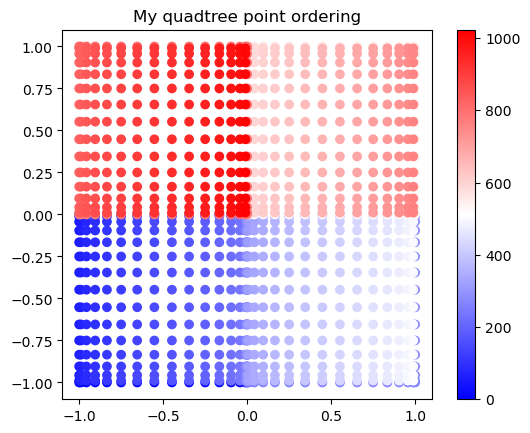

In [51]:
plt.title("My quadtree point ordering")
plt.scatter(
    *unif_to_quadtree_cheb.hps_tree_cheb_xy.T,
    c=jnp.arange(4**tree_L * tree_p**2),
    cmap="bwr"
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

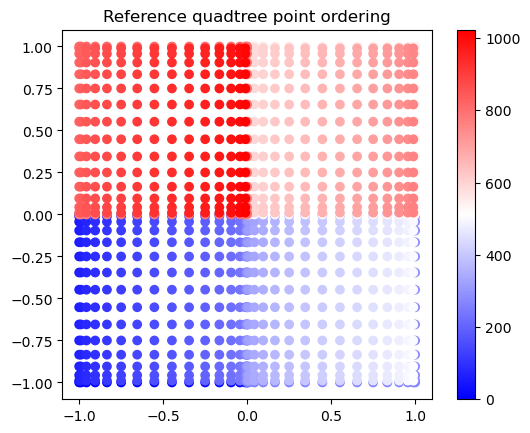

In [52]:
plt.title("Reference quadtree point ordering")
plt.scatter(
    *tree_domain.interior_points.reshape(-1,2).T,
    c=jnp.arange(4**tree_L * tree_p**2),
    cmap="bwr"
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [53]:
q_tree_cheb_fnver = (
    unif_to_quadtree_cheb.apply(ref_q_tree_unif.reshape(tree_n, tree_n))
)

In [54]:
q_tree_cheb_err = (
    jnp.linalg.norm(q_tree_cheb_fnver.flatten() - ref_q_tree_cheb.flatten())
    / jnp.linalg.norm(ref_q_tree_cheb)
)
print(f"Error in chebyshev grid: {q_tree_cheb_err:.5e}")

Error in chebyshev grid: 1.46864e-02


In [55]:
q_tree_unif_rec_fnver = quadtree_cheb_to_unif.apply(q_tree_cheb_fnver)
q_unif_rec_err = (
    jnp.linalg.norm(q_tree_unif_rec_fnver.flatten() - ref_q_tree_unif.flatten())
    / jnp.linalg.norm(ref_q_tree_unif)
)
print(f"Error in recovered uniform grid: {q_unif_rec_err:.5e}")

Error in recovered uniform grid: 8.12490e-03


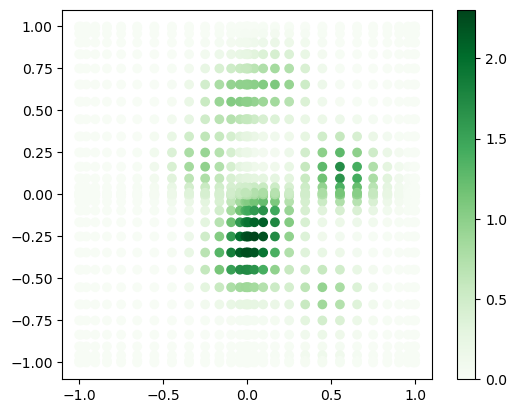

In [56]:
plt.scatter(
    # *tree_cheb_xy.T,
    *tree_domain.interior_points.reshape(-1,2).T,
    c=jnp.real(q_tree_cheb_fnver),
    cmap="Greens"
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

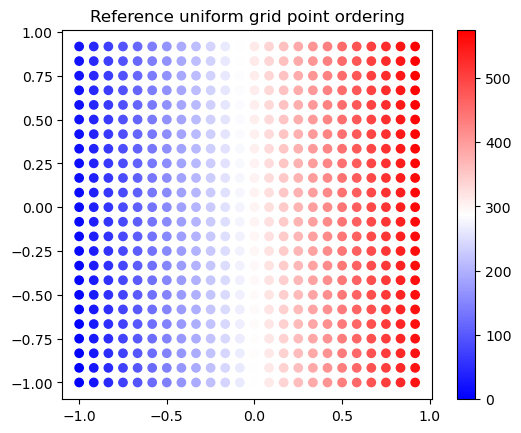

In [57]:
plt.title("Reference uniform grid point ordering")
plt.scatter(
    *tree_unif_xy.reshape(-1,2).T,
    c=jnp.arange(4**tree_L * tree_n_per_leaf**2),
    cmap="bwr"
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()